# PyCaret Anomaly Detection — Kaggle
For Kaggle: use **Add data** to attach a dataset. CSV files appear under `/kaggle/input/...`.
Run the first cell to install PyCaret 3.3.2.


Assignment Done by :- **Dev Mulchandani**

In [12]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # avoid RAPIDS/CUDA import issues on Kaggle


In [13]:
%pip -q install -U pip setuptools wheel
%pip -q install "pycaret==3.3.2"

import glob, pandas as pd
from pycaret.anomaly import *
print("✅ PyCaret ready.")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✅ PyCaret ready.


In [14]:
csvs = sorted(glob.glob('/kaggle/input/**/*.csv', recursive=True))
if not csvs:
    raise SystemExit("No CSVs under /kaggle/input. Click **Add data** on the right, attach a dataset, rerun.")

for i,p in enumerate(csvs):
    print(f"{i}: {p}")
idx = int(input("\nEnter index of the CSV to load: "))
DATA_PATH = csvs[idx]
print("✅ Using:", DATA_PATH)

data = pd.read_csv(DATA_PATH)
print("Shape:", data.shape)
display(data.head())


0: /kaggle/input/anomaly-dataset/embedded_system_network_security_dataset.csv



Enter index of the CSV to load:  0


✅ Using: /kaggle/input/anomaly-dataset/embedded_system_network_security_dataset.csv
Shape: (1000, 18)


,packet_size,inter_arrival_time,src_port,dst_port,packet_count_5s,mean_packet_size,spectral_entropy,frequency_band_energy,label,protocol_type_TCP,protocol_type_UDP,src_ip_192.168.1.2,src_ip_192.168.1.3,dst_ip_192.168.1.5,dst_ip_192.168.1.6,tcp_flags_FIN,tcp_flags_SYN,tcp_flags_SYN-ACK
0,0.405154,0.620362,62569,443,0.857143,0.0,0.834066,0.534891,0.0,False,True,True,False,False,False,False,False,False
1,0.527559,0.741288,59382,443,0.785714,0.0,0.147196,0.990757,0.0,False,True,False,False,False,True,False,True,False
2,0.226199,0.485116,65484,80,0.285714,0.0,0.855192,0.031781,0.0,False,True,False,False,True,False,False,False,False
3,0.573372,0.450965,51707,53,0.142857,0.0,0.153220,0.169958,0.0,False,False,False,True,False,False,False,False,False
4,0.651396,0.888740,26915,53,0.714286,0.0,0.923916,0.552053,0.0,True,False,False,True,False,False,False,True,False


In [16]:
# Keep only numeric columns for anomaly models
num_cols = data.select_dtypes(include="number").columns.tolist()
if not num_cols:
    raise SystemExit("Dataset has no numeric columns. Add a numeric dataset for anomaly detection.")
data_num = data[num_cols].copy()

# ✅ Remove `silent=True` (not supported)
exp = setup(
    data=data_num,
    normalize=True,
    session_id=123,
    verbose=False
)
print("✅ setup() complete.")


✅ setup() complete.


In [17]:
model = create_model('iforest')   # <- NOW 'model' exists
print("✅ model created:", model)


✅ model created: IForest(behaviour='new', bootstrap=False, contamination=0.05,
    max_features=1.0, max_samples='auto', n_estimators=100, n_jobs=-1,
    random_state=123, verbose=0)


,packet_size,inter_arrival_time,src_port,dst_port,packet_count_5s,mean_packet_size,spectral_entropy,frequency_band_energy,label,Anomaly,Anomaly_Score
0,0.405154,0.620362,62569,443,0.857143,0.0,0.834066,0.534891,0.0,0,-0.089773
1,0.527559,0.741288,59382,443,0.785714,0.0,0.147196,0.990757,0.0,0,-0.063233
2,0.226199,0.485116,65484,80,0.285714,0.0,0.855192,0.031781,0.0,0,-0.050250
3,0.573372,0.450965,51707,53,0.142857,0.0,0.153220,0.169958,0.0,0,-0.106595
4,0.651396,0.888740,26915,53,0.714286,0.0,0.923916,0.552053,0.0,0,-0.122945


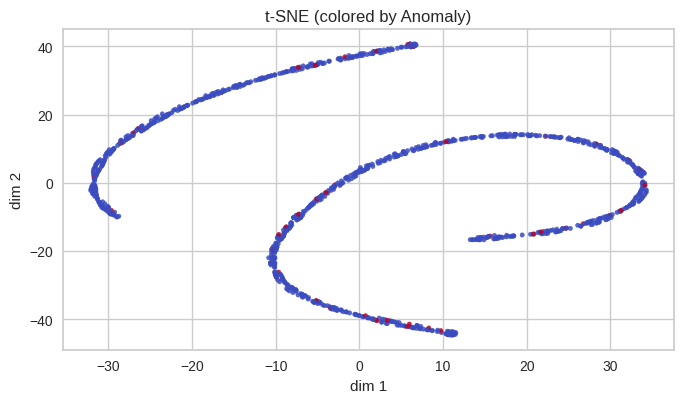

Transformation Pipeline and Model Successfully Saved
✅ Saved model: best_anomaly_model.pkl
✅ Saved labeled data: anomaly_labeled.csv (in /kaggle/working)


In [20]:
# ✅ Full anomaly post-processing cell (PyCaret 3.x compatible)

# Assumes you already ran: setup(...)  and usually model = create_model('iforest')
from pycaret.anomaly import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 1) Make sure we have a model (create a default one if missing)
if 'model' not in globals():
    model = create_model('iforest')  # Isolation Forest as a sensible default

# 2) Get anomaly labels on the training data
assigned = assign_model(model)   # adds 'Anomaly' (0/1) and 'Anomaly_Score'
display(assigned.head())

# 3) Compact t-SNE visualization with full size control (works on any PyCaret 3.x)
#    -> use only numeric features, drop label/score columns if present
drop_cols = [c for c in ['Anomaly', 'Anomaly_Score'] if c in assigned.columns]
X_num = assigned.drop(columns=drop_cols, errors='ignore').select_dtypes(include=np.number).values
y = assigned['Anomaly'].values if 'Anomaly' in assigned.columns else np.zeros(len(assigned), dtype=int)

# Guard against tiny datasets: t-SNE needs perplexity < n_samples
n = len(X_num)
if n >= 6:   # safe minimum for t-SNE
    perp = max(5, min(30, n - 1))
    tsne = TSNE(n_components=2, random_state=123, init='random', learning_rate='auto', perplexity=perp)
    emb = tsne.fit_transform(X_num)

    plt.figure(figsize=(7, 4.2))  # width, height (inches)
    plt.scatter(emb[:, 0], emb[:, 1], c=y, cmap='coolwarm', s=10, alpha=0.85)
    plt.title('t-SNE (colored by Anomaly)')
    plt.xlabel('dim 1'); plt.ylabel('dim 2')
    plt.tight_layout()
    plt.show()
else:
    print(f"Skipped t-SNE: need at least ~6 rows; got {n}.")

# 4) Save artifacts
_ = save_model(model, 'best_anomaly_model')                # saves best_anomaly_model.pkl
assigned.to_csv('anomaly_labeled.csv', index=False)        # saves labeled data

print("✅ Saved model: best_anomaly_model.pkl")
print("✅ Saved labeled data: anomaly_labeled.csv (in /kaggle/working)")

